In [1]:
import numpy as np
import pandas as pd
from scipy.stats import laplace
import scipy.stats
import psycopg2
from sklearn.metrics import mean_squared_error


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from datetime import datetime


In [2]:
param_dic = {
    "host"      : "localhost",
    "database"  : "bachelorBesoeg2014",
    "user"      : "postgres",
    "password"  : "password",
    "port"      : "5432"
}

def execRangeQuery(params_dic,dates):
    query = """
    SELECT
    sum(count_)
    FROM _775147
    WHERE
    time_ >= '{date0}'
    AND time_ <=  '{date1}'
    ;
    """.format(date0 = dates[0], date1 = dates[1])
    try:
        connection = psycopg2.connect(**params_dic)
        cursor = connection.cursor()
        cursor.execute(query)
        record = cursor.fetchall()
        return record
    except (Exception, psycopg2.Error) as error :
        connection = False
        print ("Error while connecting to PostgreSQL", error)
    finally:
        if(connection):
            cursor.close()
            connection.close()
            print("Executed query and closed connection.")

def execQuery(params_dic,query):
    try:
        connection = psycopg2.connect(**params_dic)
        cursor = connection.cursor()
        cursor.execute(query)
        record = cursor.fetchall()
        return record
    except (Exception, psycopg2.Error) as error :
        connection = False
        print ("Error while connecting to PostgreSQL", error)
    finally:
        if(connection):
            cursor.close()
            connection.close()
            print("Executed query and closed connection.")
#"""select count(*) as number_of_dates, count(DISTINCT  count_) as distinct_count from _775147;"""
query = """select time_ from _775147;"""
result = execQuery(param_dic, query)
dates = [(date[0]) for date in result]

Executed query and closed connection.


In [3]:
execRangeQuery(param_dic,('2014-01-08','2014-01-09'))[0][0]

Executed query and closed connection.


538

In [4]:
query = """select count_ from _775147;"""
result = execQuery(param_dic, query)
"""
print(result)
print(type(result))
print(type(result[0]))
print((str(result[0][0])))
"""
counts = [(count[0]) for count in result]

Executed query and closed connection.


In [5]:
zip_iterator = zip(dates, counts)
missing_dict =  dict(zip_iterator)

In [6]:
missing_dict

{datetime.date(2014, 1, 2): 239,
 datetime.date(2014, 1, 3): 118,
 datetime.date(2014, 1, 4): 129,
 datetime.date(2014, 1, 5): 2,
 datetime.date(2014, 1, 6): 293,
 datetime.date(2014, 1, 7): 362,
 datetime.date(2014, 1, 8): 288,
 datetime.date(2014, 1, 9): 250,
 datetime.date(2014, 1, 10): 76,
 datetime.date(2014, 1, 11): 89,
 datetime.date(2014, 1, 12): 1,
 datetime.date(2014, 1, 13): 253,
 datetime.date(2014, 1, 14): 364,
 datetime.date(2014, 1, 15): 241,
 datetime.date(2014, 1, 17): 388,
 datetime.date(2014, 1, 18): 80,
 datetime.date(2014, 1, 19): 4,
 datetime.date(2014, 1, 20): 315,
 datetime.date(2014, 1, 21): 365,
 datetime.date(2014, 1, 22): 266,
 datetime.date(2014, 1, 23): 244,
 datetime.date(2014, 1, 24): 51,
 datetime.date(2014, 1, 25): 88,
 datetime.date(2014, 1, 26): 5,
 datetime.date(2014, 1, 27): 260,
 datetime.date(2014, 1, 28): 353,
 datetime.date(2014, 1, 29): 251,
 datetime.date(2014, 1, 30): 288,
 datetime.date(2014, 1, 31): 116,
 datetime.date(2014, 2, 1): 176,
 d

In [7]:
print(len(dates))
print(dates[len(dates)-1])
print(dates[-1])
print((dates[-1]-dates[0]).days)

1794
2019-06-30
2019-06-30
2005


In [8]:
print(f'There should be datapoints {(dates[-1]-dates[0]).days}')
print(f'There is {len(dates)} datapoints')
print(f'So we are missing {(dates[-1]-dates[0]).days - len(dates)} datapoints')

There should be datapoints 2005
There is 1794 datapoints
So we are missing 211 datapoints


In [9]:
T = 1794
print(np.log2(1794))
print(int(np.ceil(np.log2(1794))))
print(2**np.ceil(np.log2(1794)))


10.80896417491926
11
2048.0


In [10]:
def get_index(date_idx, n_layers):
    """Calculates the path of index in full binary string

    Parameters:
    date_idx (int): The node in the bouttom layer we want to calculate a path to. 
    The bottom layer has index from 0 to 2**h-1
    n_layers (int): The height of the full binary tree. 

    Returns:
    list: of index in the path from the starting from the bottom and going up

    """
    idx = []
    for i in np.arange(0,n_layers):
        if i == 0:
            idx.append(int(date_idx))
        else:
            idx.append(int(idx[i-1]//2))
    idx.append(0)
    return idx

In [11]:
T = len(dates)
print(T)
T = 2**np.ceil(np.log2(T))
print(T)
n_layers = int(np.log2(T))
print(f'n_layers = {n_layers}')
print(get_index(2**np.ceil(np.log2(T))-1,n_layers))

1794
2048.0
n_layers = 11
[2047, 1023, 511, 255, 127, 63, 31, 15, 7, 3, 1, 0]


In [12]:
print(get_index(0,1))
print(get_index(0,2))
print(get_index(0,3))
print(get_index(12,4))

[0, 0]
[0, 0, 0]
[0, 0, 0, 0]
[12, 6, 3, 1, 0]


In [13]:
print(get_index(0,n_layers))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [14]:
class con_obs:
    
    def __init__(self, epsilon, dates, counts):
        """Setup of the datastructere

        Parameters:
        T (int): The lenght of the stream
        epsilon (float): The height of the full binary tree. 
        dates (Array): The dates of the stream
        counts (Array): The count for each of the dates
        Returns:
        A epsilon differintial datastructe
        """
        self.dates = dates
        self.real_counts = counts
        #Check if we are we have missing dates.
        if len(dates) < (dates[-1]-dates[0]).days:  
            self.dates = self.__add_missing_dates(dates)
            self.real_counts = self.__add_missing_counts(counts,dates)
            
        
        #Make dict for date indexing
        values = np.arange(0,len(self.dates))
        zip_iterator = zip(self.dates, values)
        self.idx_dict =  dict(zip_iterator)
        
        
        
        
        # We need the stream to be a power of 2
        self.T = int(2**np.ceil(np.log2(len(self.dates))))
        self.epsilon = epsilon
        self.zeta = (np.log2(self.T))/epsilon
        # The height of the "Binary tree"
        self.n_layers = int(np.log2(self.T))
        
        # Get laplace for each node
        self.laplaces = self.__init_laplace()
        self.noise_counts = self.__process(self.real_counts)
        
        
        
    def __add_missing_dates(self, old_dates):
        """Add missing dates in a list
        Parameters:
        old_dates (list of datetime.date): List of dates that is not countious
        Returns:
        List of countious starting with the first value of 
        """
        start_date = dates[0]
        end_date = dates[-1]
        all_dates = pd.date_range(start = start_date, end = end_date).to_pydatetime().tolist()
        return [(date.date()) for date in all_dates]
    
    def __add_missing_counts(self, old_counts, old_dates):
        """Adds 0 to the list of counts where there was missing dates
        Parameters:
        old_counts (list of int): List counts for each day with 
        old_dates (list of datetime.date): List of dates that is not countious
        Returns:
        List of countious starting with the first value of 
        """
        zip_iterator = zip(old_dates, old_counts)
        missing_dict =  dict(zip_iterator)
        all_counts = np.zeros(len(self.dates))
        for i, date in enumerate(self.dates):
            val = missing_dict.get(date, 0)
            all_counts[i] = val
            
        return all_counts
    
    def __init_laplace(self):
        """
        returns: list of arrays with the correct size of laplaces variabels.
        """
        laplaces = []
        for i in np.arange(0,self.n_layers+1):
            rvs = laplace(scale=self.zeta).rvs(int(2**np.ceil(i)))
            laplaces.append(rvs)
        
        return laplaces
    
    
    def __process(self, counts):
               
        noise_counts = np.zeros(len(self.dates))
        for idx, date_count in enumerate(counts):
            indices = self.get_index(idx,self.n_layers)
            indices.reverse()
            laplace_sum = 0.0
            for laplace_idx, laplace_row in enumerate(self.laplaces):
                laplace_sum = laplace_sum + laplace_row[indices[laplace_idx]]
            noise_counts[idx] = date_count  +  noise_counts[idx-1] + laplace_sum
        return noise_counts
    
    def get_index(self, date_idx, n_layers):
        """Calculates the path of index in full binary string

        Parameters:
        date_idx (int): The node in the bouttom layer we want to calculate a path to. 
        The bottom layer has index from 0 to 2**h-1
        n_layers (int): The height of the full binary tree. 

        Returns:
        list: of index in the path from the starting from the bottom and going up
        """
        idx = []
        for i in np.arange(0,n_layers):
            if i == 0:
                idx.append(int(date_idx))
            else:
                idx.append(int(idx[i-1]//2))
        idx.append(0)
        return idx
    
    def answer(self, dates):
        """Calculates the path of index in full binary string

        Parameters:
        dates (tuple of string): Two dates in the format string 2000-12-19. 

        Returns:
        float: The private range count
        """
            
        if (len(dates) < 2):
            date_obj_0 = datetime.strptime(dates[0],'%Y-%m-%d').date()
            #print(date_obj_0)
            #print(type(date_obj_0))
            idx = self.idx_dict[date_obj_0]
            if idx:
                #Index is not 0
                return self.noise_counts[idx] - self.noise_counts[idx-1]            
            else:
                return self.noise_counts[idx]
        else:
            date_obj_0 = datetime.strptime(dates[0],'%Y-%m-%d').date()
            date_obj_1 = datetime.strptime(dates[1],'%Y-%m-%d').date()
            idx_0 = self.idx_dict[date_obj_0]
            idx_1 = self.idx_dict[date_obj_1]
            
            #idx_0 is not 0
            if idx_0:
                return self.noise_counts[idx_1] - self.noise_counts[idx_0-1]            
            else:
                return self.noise_counts[idx_1]
            
        
    def real_answer(self, dates):
        if len(dates) < 2:
            date_obj_0 = datetime.strptime(dates[0],'%Y-%m-%d').date()
            return self.real_counts[self.idx_dict[date_obj_0]]
        else:
            date_obj_0 = datetime.strptime(dates[0],'%Y-%m-%d').date()
            date_obj_1 = datetime.strptime(dates[1],'%Y-%m-%d').date()
            sum_ = np.sum(self.real_counts[self.idx_dict[date_obj_0]: self.idx_dict[date_obj_1]+1])  
            return sum_

        
        

T = len(dates)
epsilon = 0.7
c_o = con_obs(epsilon, dates, counts)

In [20]:
query_dates = ('2014-01-08','2014-01-09')
print(c_o.answer(query_dates))
print(c_o.real_answer(query_dates))
print(execRangeQuery(param_dic,query_dates)[0][0])

print(c_o.answer(('2014-01-20',)))
print(c_o.real_answer(('2014-01-20',)))

print(c_o.answer(('2014-01-02','2014-01-05')))
print(c_o.real_answer(('2014-01-02','2014-01-05')))



for key, value in c_o.idx_dict.items():
    print(key, ' : ', value)

473.35197727852983
538.0
Executed query and closed connection.
538
344.47600362673074
315.0
776.9662876939236
488.0
2014-01-02  :  0
2014-01-03  :  1
2014-01-04  :  2
2014-01-05  :  3
2014-01-06  :  4
2014-01-07  :  5
2014-01-08  :  6
2014-01-09  :  7
2014-01-10  :  8
2014-01-11  :  9
2014-01-12  :  10
2014-01-13  :  11
2014-01-14  :  12
2014-01-15  :  13
2014-01-16  :  14
2014-01-17  :  15
2014-01-18  :  16
2014-01-19  :  17
2014-01-20  :  18
2014-01-21  :  19
2014-01-22  :  20
2014-01-23  :  21
2014-01-24  :  22
2014-01-25  :  23
2014-01-26  :  24
2014-01-27  :  25
2014-01-28  :  26
2014-01-29  :  27
2014-01-30  :  28
2014-01-31  :  29
2014-02-01  :  30
2014-02-02  :  31
2014-02-03  :  32
2014-02-04  :  33
2014-02-05  :  34
2014-02-06  :  35
2014-02-07  :  36
2014-02-08  :  37
2014-02-09  :  38
2014-02-10  :  39
2014-02-11  :  40
2014-02-12  :  41
2014-02-13  :  42
2014-02-14  :  43
2014-02-15  :  44
2014-02-16  :  45
2014-02-17  :  46
2014-02-18  :  47
2014-02-19  :  48
2014-02-20  

2015-03-13  :  435
2015-03-14  :  436
2015-03-15  :  437
2015-03-16  :  438
2015-03-17  :  439
2015-03-18  :  440
2015-03-19  :  441
2015-03-20  :  442
2015-03-21  :  443
2015-03-22  :  444
2015-03-23  :  445
2015-03-24  :  446
2015-03-25  :  447
2015-03-26  :  448
2015-03-27  :  449
2015-03-28  :  450
2015-03-29  :  451
2015-03-30  :  452
2015-03-31  :  453
2015-04-01  :  454
2015-04-02  :  455
2015-04-03  :  456
2015-04-04  :  457
2015-04-05  :  458
2015-04-06  :  459
2015-04-07  :  460
2015-04-08  :  461
2015-04-09  :  462
2015-04-10  :  463
2015-04-11  :  464
2015-04-12  :  465
2015-04-13  :  466
2015-04-14  :  467
2015-04-15  :  468
2015-04-16  :  469
2015-04-17  :  470
2015-04-18  :  471
2015-04-19  :  472
2015-04-20  :  473
2015-04-21  :  474
2015-04-22  :  475
2015-04-23  :  476
2015-04-24  :  477
2015-04-25  :  478
2015-04-26  :  479
2015-04-27  :  480
2015-04-28  :  481
2015-04-29  :  482
2015-04-30  :  483
2015-05-01  :  484
2015-05-02  :  485
2015-05-03  :  486
2015-05-04  

2017-07-25  :  1300
2017-07-26  :  1301
2017-07-27  :  1302
2017-07-28  :  1303
2017-07-29  :  1304
2017-07-30  :  1305
2017-07-31  :  1306
2017-08-01  :  1307
2017-08-02  :  1308
2017-08-03  :  1309
2017-08-04  :  1310
2017-08-05  :  1311
2017-08-06  :  1312
2017-08-07  :  1313
2017-08-08  :  1314
2017-08-09  :  1315
2017-08-10  :  1316
2017-08-11  :  1317
2017-08-12  :  1318
2017-08-13  :  1319
2017-08-14  :  1320
2017-08-15  :  1321
2017-08-16  :  1322
2017-08-17  :  1323
2017-08-18  :  1324
2017-08-19  :  1325
2017-08-20  :  1326
2017-08-21  :  1327
2017-08-22  :  1328
2017-08-23  :  1329
2017-08-24  :  1330
2017-08-25  :  1331
2017-08-26  :  1332
2017-08-27  :  1333
2017-08-28  :  1334
2017-08-29  :  1335
2017-08-30  :  1336
2017-08-31  :  1337
2017-09-01  :  1338
2017-09-02  :  1339
2017-09-03  :  1340
2017-09-04  :  1341
2017-09-05  :  1342
2017-09-06  :  1343
2017-09-07  :  1344
2017-09-08  :  1345
2017-09-09  :  1346
2017-09-10  :  1347
2017-09-11  :  1348
2017-09-12  :  1349


In [16]:
def relative_error_percentage(x_approx, x_true):
    # | (V - Vapprox) / V | x 100% 
    return np.abs((x_true-x_approx)/x_true)*100


def relative_error(x_approx, x_true):
    # | 1 - (Vapprox / V) | 
    return np.abs(1-(x_approx/x_true))
 

In [18]:
epsilons = np.array([2,1.4,1.2,1,0.8,0.7,0.5,0.4,0.3])

In [20]:
error_dicts = {}

for e in epsilons:
    print(e)
    number_of_queries = 100
    range_dates = ('2014-01-08','2014-01-09')
    answears = np.zeros(number_of_queries)
    corret_answear = execRangeQuery(param_dic,range_dates)[0][0]
    for i in range(0,number_of_queries):
        c_o = con_obs(epsilon, dates, counts)
        answears[i] = c_o.answer(('2014-01-08','2014-01-09'))
    error = np.abs(corret_answear-answears)
    max_error = np.amax(error)
    min_error = np.amin(error)
    true_values = np.full(number_of_queries, corret_answear)
    vfunc = np.vectorize(relative_error)
    rel_erorrs = vfunc(answears, corret_answear)
    mse = mean_squared_error(true_values, answears)
    error_dicts[e] = {'mse': mse, 'max': max_error, 'min': min_error, 'rel': np.mean(rel_erorrs), 'abs': np.mean(error)}



2.0
Executed query and closed connection.
1.4
Executed query and closed connection.
1.2
Executed query and closed connection.
1.0
Executed query and closed connection.
0.8
Executed query and closed connection.
0.7
Executed query and closed connection.
0.5
Executed query and closed connection.
0.4
Executed query and closed connection.
0.3
Executed query and closed connection.


In [30]:
#Getting all error values from dict
n = len(error_dicts)
mse_errors = np.zeros(n)
min_errors = np.zeros(n)
max_errors = np.zeros(n)
rel_errors = np.zeros(n)
abs_errors = np.zeros(n)

for num, item in enumerate(error_dicts.items()):
    mse_errors[num] = item[1]['mse']
    min_errors[num] = item[1]['min']
    max_errors[num] = item[1]['max']
    rel_errors[num] = item[1]['rel']
    abs_errors[num] = item[1]['abs']

In [31]:
error_stack = np.vstack((min_errors,mse_errors,max_errors,rel_errors,abs_errors)).flatten()
min_labels = np.full(min_errors.size, 'min errors')
mse_labels = np.full(mse_errors.size, 'mse errors')
max_labels = np.full(max_errors.size, 'max errors')
rel_labels = np.full(rel_errors.size, 'rel errors')
abs_labels = np.full(rel_errors.size, 'abs errors')


labels_stack = np.vstack((min_labels,mse_labels,max_labels,rel_labels,abs_labels)).flatten()
epsilons_stack = np.vstack((epsilons,epsilons,epsilons,epsilons,epsilons)).flatten()


In [32]:
seaborn_df = pd.DataFrame({'epsilons':epsilons_stack, 'errors':error_stack,'labels':labels_stack})
seaborn_df.to_csv('con_obs_seaborn_plotting_data.csv',index=False)

In [33]:
all_data = pd.DataFrame({'epsilons':epsilons, 'min_errors':min_errors,'max_errors':min_errors,'mse_errors':mse_errors,'rel_errors':rel_errors,'abs_errors':abs_errors})
all_data.to_csv('con_obs_plotting_data.csv',index=False)

In [34]:
sns.set()

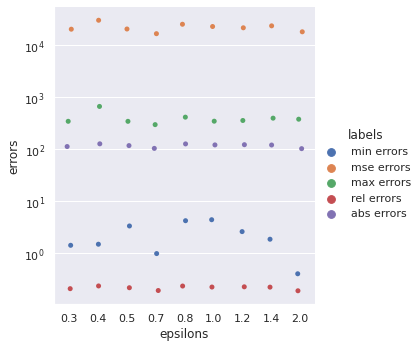

In [35]:
sns_plot = sns.catplot(x="epsilons", y="errors", hue="labels", data=seaborn_df)
sns_plot.set(yscale="log")
sns_plot.savefig("con_AllErrors.png")


In [ ]:
sns_plot = sns.scatterplot(data=seaborn_df.loc[seaborn_df['labels'] == 'min errors'], x ='epsilons', y ='errors')
plt.legend(labels=['min errors'])
sns_plot.get_figure().savefig('con_min_error.png') 

In [ ]:
sns_plot = sns.scatterplot(data=seaborn_df.loc[seaborn_df['labels'] == 'max errors'], x ='epsilons', y ='errors')
plt.legend(labels=['max errors'])
sns_plot.get_figure().savefig('con_max_error.png') 

In [ ]:
sns_plot = sns.scatterplot(data=seaborn_df.loc[seaborn_df['labels'] == 'mse errors'], x ='epsilons', y ='errors')
plt.legend(labels=['mse errors'])
sns_plot.get_figure().savefig('con_mse_error.png') 

In [ ]:
sns_plot = sns.scatterplot(data=seaborn_df.loc[seaborn_df['labels'] == 'rel errors'], x ='epsilons', y ='errors')
plt.legend(labels=['rel errors'])
sns_plot.get_figure().savefig('con_rel_error.png') 

In [16]:
#print(dates)
print(counts)

[239, 118, 129, 2, 293, 362, 288, 250, 76, 89, 1, 253, 364, 241, 388, 80, 4, 315, 365, 266, 244, 51, 88, 5, 260, 353, 251, 288, 116, 176, 126, 675, 269, 272, 87, 168, 6, 261, 239, 257, 251, 54, 471, 445, 328, 351, 78, 69, 20, 333, 390, 326, 286, 103, 128, 30, 290, 388, 362, 269, 76, 285, 33, 329, 81, 607, 296, 87, 109, 53, 308, 354, 326, 378, 94, 56, 381, 353, 167, 466, 174, 179, 798, 299, 350, 440, 232, 107, 454, 316, 235, 278, 71, 111, 17, 214, 203, 160, 8, 1, 1, 1, 343, 308, 279, 101, 65, 53, 308, 485, 275, 21, 75, 101, 74, 347, 355, 280, 318, 90, 94, 36, 310, 437, 262, 248, 1, 52, 15, 334, 361, 332, 214, 77, 150, 34, 330, 357, 284, 1, 12, 63, 325, 387, 281, 15, 21, 102, 5, 3, 508, 263, 338, 90, 79, 9, 302, 354, 279, 325, 99, 114, 35, 329, 333, 258, 321, 117, 150, 17, 245, 260, 230, 223, 115, 1, 11, 242, 214, 185, 209, 16, 2, 1, 212, 209, 174, 203, 30, 58, 17, 237, 195, 144, 229, 110, 28, 57, 239, 171, 188, 234, 76, 54, 3, 268, 222, 217, 246, 87, 74, 12, 319, 328, 246, 263, 76, 98, 

In [18]:
def get_group(n_layers, level, degree):
        """Calculates the path of index in full binary string

        Parameters:
        date_idx (int): The node in the bouttom layer we want to calculate a path to. 
        The bottom layer has index from 0 to 2**h-1
        n_layers (int): The height of the full binary tree. 0 index

        Returns:
        list: of index in the path from the starting from the bottom and going up

        """
        if level == 0:
            return 0
        else:
            group_index = idx //degree
            level_indicis = np.arange(0,degree**level)

            split_ratio = (len(level_indicis) // degree)
            level_indicis_split = np.array_split(level_indicis, split_ratio)

            return level_indicis_split[group_index]

In [109]:
def pad_counts(counts, degree):
    levels = int(np.ceil(np.log(len(counts)) / np.log(degree)))

    n_missing_counts =  degree**levels -len(counts)

    missing = np.zeros(n_missing_counts, dtype=int)
    new_counts = np.concatenate((counts,missing))
    return new_counts

def pad_dates(dates, degree):
    levels = int(np.ceil(np.log(len(dates)) / np.log(degree)))
    n_missing_dates =  degree**levels - len(dates)

    start_date = datetime.strptime(str(dates[-1]),'%Y-%m-%d').date()
    result = pd.date_range(start = start_date, periods = n_missing_dates).to_pydatetime().tolist()

    new_dates = np.concatenate((counts,result))
    return new_dates

degree = 2
pad_counts(counts,degree)
pad_dates(dates,degree)

array([239, 118, 129, ..., datetime.datetime(2020, 3, 7, 0, 0),
       datetime.datetime(2020, 3, 8, 0, 0),
       datetime.datetime(2020, 3, 9, 0, 0)], dtype=object)

In [114]:
def build_histogram(counts, degree):
    #print(counts)
    #print(get_group(counts,degree))
    tree = []
    left = counts
    for level in range(0, int(np.ceil(np.log(len(counts)) / np.log(degree)))):
        #print(level)
        #print(degree**level)
        split_ratio = degree**level
        left = np.array_split(counts, split_ratio)
        #print(left)
        #print(len(left))
        sums = [np.sum(a) for a in left]
        print(sums)
        #print(left)
        #print(len(left))

degree = 3
padded_counts = pad_counts(counts,degree)
padded_dates = pad_dates(dates,degree)
build_histogram(padded_counts, degree)
#print(len(counts))
#print(math.log(len(counts),degree))

[419393]
[161022, 192718, 65653]
[49652, 60159, 51211, 53510, 89350, 49858, 47910, 17743, 0]
[18300, 16256, 15096, 19889, 19013, 21257, 15569, 17654, 17988, 20817, 18309, 14384, 55649, 16415, 17286, 17479, 17390, 14989, 13186, 16154, 18570, 15213, 2530, 0, 0, 0, 0]
[5375, 6445, 6480, 5624, 5652, 4980, 4342, 4322, 6432, 6082, 6902, 6905, 4880, 7140, 6993, 8981, 6366, 5910, 5932, 5590, 4047, 5769, 6179, 5706, 6711, 6399, 4878, 6526, 7076, 7215, 6094, 5771, 6444, 3760, 4429, 6195, 6464, 6258, 42927, 6758, 5519, 4138, 5565, 5986, 5735, 6300, 5258, 5921, 5486, 7262, 4642, 4877, 5561, 4551, 2912, 4719, 5555, 5584, 5959, 4611, 5584, 5562, 7424, 5425, 4370, 5418, 2530, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1757, 1735, 1883, 2177, 2312, 1956, 1861, 2224, 2395, 3175, 1297, 1152, 2041, 2075, 1536, 1793, 1536, 1651, 1805, 1481, 1056, 1075, 1455, 1792, 1730, 2198, 2504, 1660, 1942, 2480, 1951, 2801, 2150, 1745, 2305, 2855, 2158, 1863, 859, 1931, 2599, 2610, 2378, 1829, 2786, 2779, 2443, 3759, 

In [37]:
import math
idx = 64
degree = 4
print(math.log(idx,degree))
print(int(np.log(idx+degree) / np.log(degree)))

3.0
3
